In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [2]:
df = pd.read_csv('data_model.csv')

In [3]:
df.head()

,nombre,Ciencias naturales-nota_p1,Ciencias naturales-nota_p2,Ciencias naturales-nota_p3,Ciencias naturales-nota_p4,Ciencias sociales-nota_p1,Ciencias sociales-nota_p2,Ciencias sociales-nota_p3,Ciencias sociales-nota_p4,Educación artística-nota_p1,...,Tecnología e informática-nota_p3,Tecnología e informática-nota_p4,Humanidades-nota_p1,Humanidades-nota_p2,Humanidades-nota_p3,Humanidades-nota_p4,fecha,segment,firstLabel,secondLabel
0,ACEVEDO MOLANO MATIAS,3.0,4.0,4.0,4.0,3.0,4.0,4.0,4.0,3.0,...,3.0,3.0,3.0,3.0,3.0,4.0,2021-03-01,SEGUNDO,WhiteFlag,WhiteFlag
1,ACEVEDO MOLANO THOMAS,3.0,4.0,4.0,4.0,3.0,3.0,3.0,4.0,3.0,...,3.0,3.0,3.0,3.0,3.0,3.0,2021-03-01,QUINTO,WhiteFlag,WhiteFlag
2,ACEVEDO VELEZ MARIA FERNANDA,3.0,3.0,4.0,4.0,4.0,3.0,2.0,3.0,3.0,...,2.0,4.0,3.0,3.0,3.0,3.0,2021-03-01,DIEZ,WhiteFlag,YellowFlag
3,ACOSTA BASTO SARA SOFIA,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,...,3.0,3.0,3.0,4.0,4.0,3.0,2021-03-01,TERCERO,WhiteFlag,WhiteFlag
4,AGUDELO ARANGO FEDERICO,4.0,2.0,2.0,2.0,4.0,3.0,2.0,2.0,4.0,...,4.0,4.0,3.0,2.0,2.0,3.0,2021-03-01,OCHO,WhiteFlag,OrangeFlag


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26733 entries, 0 to 26732
Data columns (total 45 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   nombre                              26733 non-null  object 
 1   Ciencias naturales-nota_p1          26733 non-null  float64
 2   Ciencias naturales-nota_p2          26733 non-null  float64
 3   Ciencias naturales-nota_p3          26733 non-null  float64
 4   Ciencias naturales-nota_p4          26733 non-null  float64
 5   Ciencias sociales-nota_p1           26733 non-null  float64
 6   Ciencias sociales-nota_p2           26733 non-null  float64
 7   Ciencias sociales-nota_p3           26733 non-null  float64
 8   Ciencias sociales-nota_p4           26733 non-null  float64
 9   Educación artística-nota_p1         26733 non-null  float64
 10  Educación artística-nota_p2         26733 non-null  float64
 11  Educación artística-nota_p3         26733

# MODELOS

In [5]:
def data_split(examples, labels, train_frac, random_state=None):
    ''' https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html
    param data:       Data to be split
    param train_frac: Ratio of train set to whole dataset

    Randomly split dataset, based on these ratios:
        'train': train_frac
        'valid': (1-train_frac) / 2
        'test':  (1-train_frac) / 2

    Eg: passing train_frac=0.8 gives a 80% / 10% / 10% split
    '''

    assert train_frac >= 0 and train_frac <= 1, "Invalid training set fraction"

    X_train, X_tmp, Y_train, Y_tmp = train_test_split(
                                        examples, labels, train_size=train_frac, random_state=random_state)

    X_val, X_test, Y_val, Y_test   = train_test_split(
                                        X_tmp, Y_tmp, train_size=0.5, random_state=random_state)

    return X_train, X_val, X_test,  Y_train, Y_val, Y_test

In [6]:
def confu_matrix(y_test,y_pred):
	df = pd.DataFrame(list(zip(y_test,y_pred)), columns = ['y_test','y_pred'])
	confusion_matrix = pd.crosstab(df['y_test'], df['y_pred'], rownames=['Actual'], colnames=['Predicted'])
	sns.heatmap(confusion_matrix, annot=True)
	plt.show()

## XGBClassifier

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from imblearn.combine import SMOTETomek
from sklearn.metrics import classification_report

### Primer modelo con la firtLabel 

In [8]:
X = df.drop(['fecha','firstLabel','secondLabel','nombre'],axis=1)
y = df['firstLabel']
#Dummy variable for ‘segment’ column
segment = pd.get_dummies(X['segment'], drop_first = True)
#Dropping the original ‘segment’
X = X.drop(['segment'], axis = 1)
#Adding the dummy columns to the dataset
X = pd.concat([X,segment], axis = 1)

y = y.replace(['GreenFlag', 'WhiteFlag', 'YellowFlag', 'OrangeFlag', 'RedFlag'],[0,1,2,3,4])

X_train, X_val, X_test, y_train, y_val, y_test = data_split(X,y,0.7)
os_us = SMOTETomek()
X_train_, y_train_ = os_us.fit_resample(X_train, y_train)

<AxesSubplot:title={'center':'Balanceados'}>

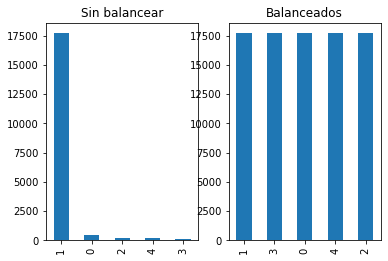

In [9]:
plt.show()
plt.subplot(221)
plt.subplot(1, 2, 1)
y_train.value_counts().plot(kind='bar',title='Sin balancear')
plt.subplot(1, 2, 2)
y_train_.value_counts().plot(kind='bar',title='Balanceados')

In [10]:
X = df.drop(['fecha','firstLabel','secondLabel','nombre'],axis=1)
y = df['firstLabel']
#Dummy variable for ‘segment’ column
segment = pd.get_dummies(X['segment'], drop_first = True)
#Dropping the original ‘segment’
X = X.drop(['segment'], axis = 1)
#Adding the dummy columns to the dataset
X = pd.concat([X,segment], axis = 1)
y = y.replace(['GreenFlag', 'WhiteFlag', 'YellowFlag', 'OrangeFlag', 'RedFlag'],[0,1,2,3,4])

X_train, X_val, X_test, y_train, y_val, y_test = data_split(X,y,0.7)
os_us = SMOTETomek()
X_train_, y_train_ = os_us.fit_resample(X_train, y_train)

model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
model.fit(X_train_, y_train_)
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print('accuracy:',accuracy)

accuracy: 0.9755610972568578


In [11]:
report = classification_report(y_test,y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.96      0.77      0.86        97
           1       0.98      1.00      0.99      3818
           2       0.50      0.06      0.11        50
           3       0.17      0.06      0.09        17
           4       0.83      0.71      0.77        28

    accuracy                           0.98      4010
   macro avg       0.69      0.52      0.56      4010
weighted avg       0.97      0.98      0.97      4010



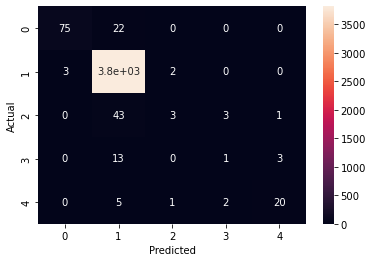

In [12]:
confu_matrix(y_test,y_pred)

### Optimization

In [ ]:
X = df.drop(['fecha','firstLabel','secondLabel','nombre'],axis=1)
y = df['firstLabel']
#Dummy variable for ‘segment’ column
segment = pd.get_dummies(X['segment'], drop_first = True)
#Dropping the original ‘segment’
X = X.drop(['segment'], axis = 1)
#Adding the dummy columns to the dataset
X = pd.concat([X,segment], axis = 1)
y = y.replace(['GreenFlag', 'WhiteFlag', 'YellowFlag', 'OrangeFlag', 'RedFlag'],[0,1,2,3,4])

# Split data into train and test sets
X_train, X_val, X_test, y_train, y_val, y_test = data_split(X,y,0.7)
os_us = SMOTETomek()
X_train_, y_train_ = os_us.fit_resample(X_train, y_train)

'''
# Define the model
xgb_model = XGBClassifier()

# Define the parameter grid
param_grid = {
    'max_depth': np.arange(3, 10, 2),
    'learning_rate': [0.05, 0.1, 0.15, 0.2],
    'n_estimators': [50, 100, 150, 200],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'reg_alpha': [0, 0.5, 1],
    'reg_lambda': [1, 1.5, 2],
    'scale_pos_weight': [1, 2, 3, 4],
    'min_child_weight': [1, 2, 3]
}

# Define the random search
random_search = RandomizedSearchCV(xgb_model, param_distributions=param_grid, n_iter=100, cv=5, 
                                   scoring='f1_micro', n_jobs=-1, random_state=42)

# Fit the random search
random_search.fit(X_train_, y_train_)

# Print the best parameters
print(random_search.best_params_)
'''

In [134]:
X = df.drop(['fecha','firstLabel','secondLabel','nombre'],axis=1)
y = df['firstLabel']
#Dummy variable for ‘segment’ column
segment = pd.get_dummies(X['segment'], drop_first = True)
#Dropping the original ‘segment’
X = X.drop(['segment'], axis = 1)
#Adding the dummy columns to the dataset
X = pd.concat([X,segment], axis = 1)
y = y.replace(['GreenFlag', 'WhiteFlag', 'YellowFlag', 'OrangeFlag', 'RedFlag'],[0,1,2,3,4])

X_train, X_val, X_test, y_train, y_val, y_test = data_split(X,y,0.7)
os_us = SMOTETomek()
X_train_, y_train_ = os_us.fit_resample(X_train, y_train)

model = XGBClassifier(subsample=0.8, scale_pos_weight=2, reg_lambda=2, 
                      reg_alpha=0, n_estimators=100, min_child_weight=1, 
                      max_depth=9, learning_rate=0.1, colsample_bytree=1.0)
model.fit(X_train_, y_train_)
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print('accuracy:',accuracy)

[10:33:48] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-37/xgboost/src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


accuracy: 0.9453855878634639


In [135]:
report = classification_report(y_test,y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.96      1.00      0.98      3707
           1       0.28      0.10      0.15       121
           2       0.20      0.07      0.11        55
           3       0.27      0.11      0.15        28
           4       0.74      0.57      0.64        44

    accuracy                           0.95      3955
   macro avg       0.49      0.37      0.41      3955
weighted avg       0.92      0.95      0.93      3955



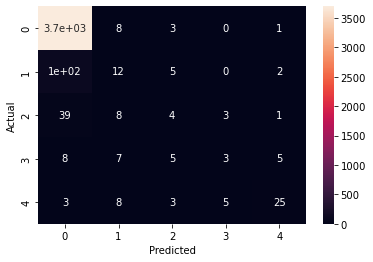

In [136]:
confu_matrix(y_test,y_pred)

### Segundo modelo con la secondLabel 

<AxesSubplot:title={'center':'Balanceados'}>

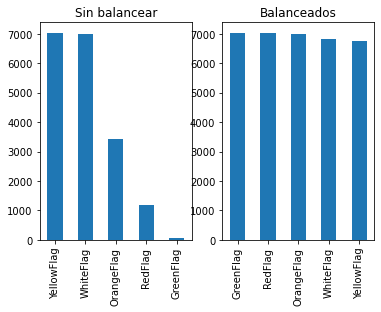

In [8]:
X = df.drop(['fecha','firstLabel','secondLabel','nombre'],axis=1)
y = df['secondLabel']
#Dummy variable for ‘segment’ column
segment = pd.get_dummies(X['segment'], drop_first = True)
#Dropping the original ‘segment’
X = X.drop(['segment'], axis = 1)
#Adding the dummy columns to the dataset
X = pd.concat([X,segment], axis = 1)

#y = y.replace(['GreenFlag', 'WhiteFlag', 'YellowFlag', 'OrangeFlag', 'RedFlag'],[0,1,2,3,4])

X_train, X_val, X_test, y_train, y_val, y_test = data_split(X,y,0.7)
os_us = SMOTETomek()
X_train_, y_train_ = os_us.fit_resample(X_train, y_train)

plt.show()
plt.subplot(221)
plt.subplot(1, 2, 1)
y_train.value_counts().plot(kind='bar',title='Sin balancear')
plt.subplot(1, 2, 2)
y_train_.value_counts().plot(kind='bar',title='Balanceados')

<AxesSubplot:title={'center':'Balanceados'}>

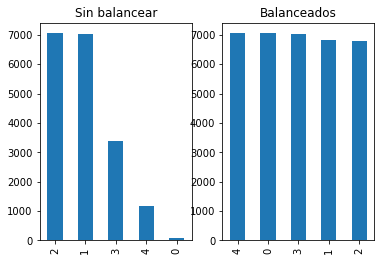

In [9]:
X = df.drop(['fecha','firstLabel','secondLabel','nombre'],axis=1)
y = df['secondLabel']
#Dummy variable for ‘segment’ column
segment = pd.get_dummies(X['segment'], drop_first = True)
#Dropping the original ‘segment’
X = X.drop(['segment'], axis = 1)
#Adding the dummy columns to the dataset
X = pd.concat([X,segment], axis = 1)

y = y.replace(['GreenFlag', 'WhiteFlag', 'YellowFlag', 'OrangeFlag', 'RedFlag'],[0,1,2,3,4])

X_train, X_val, X_test, y_train, y_val, y_test = data_split(X,y,0.7)
os_us = SMOTETomek()
X_train_, y_train_ = os_us.fit_resample(X_train, y_train)

plt.show()
plt.subplot(221)
plt.subplot(1, 2, 1)
y_train.value_counts().plot(kind='bar',title='Sin balancear')
plt.subplot(1, 2, 2)
y_train_.value_counts().plot(kind='bar',title='Balanceados')

In [10]:
X = df.drop(['fecha','firstLabel','secondLabel','nombre'],axis=1)
y = df['secondLabel']
#Dummy variable for ‘segment’ column
segment = pd.get_dummies(X['segment'], drop_first = True)
#Dropping the original ‘segment’
X = X.drop(['segment'], axis = 1)
#Adding the dummy columns to the dataset
X = pd.concat([X,segment], axis = 1)
y = y.replace(['GreenFlag', 'WhiteFlag', 'YellowFlag', 'OrangeFlag', 'RedFlag'],[0,1,2,3,4])

X_train, X_val, X_test, y_train, y_val, y_test = data_split(X,y,0.7)
os_us = SMOTETomek()
X_train_, y_train_ = os_us.fit_resample(X_train, y_train)

model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
model.fit(X_train_, y_train_)
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print('accuracy:',accuracy)

accuracy: 0.9159600997506234


In [11]:
prueba = X.iloc[0].values
#prueba = pd.DataFrame(prueba)
prueba.shape

(50,)

In [12]:
X.iloc[0].values

array([3., 4., 4., 4., 3., 4., 4., 4., 3., 3., 3., 3., 3., 3., 3., 3., 4.,
       2., 2., 4., 4., 3., 3., 3., 4., 4., 4., 4., 3., 3., 3., 3., 3., 3.,
       3., 3., 3., 3., 3., 4., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.])

In [13]:
model

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='mlogloss', gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_bin=256, max_cat_to_onehot=4, max_delta_step=0, max_depth=6,
              max_leaves=0, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=0,
              num_parallel_tree=1, objective='multi:softprob', predictor='auto',
              random_state=0, reg_alpha=0, ...)

In [21]:
#import pickle
#pickle.dump(model, open('model.pickle', 'wb'))

In [14]:
model.save_model("model.json")

In [60]:
with open('model.pickle', 'rb') as f:
    pred_model = pickle.load(f)

In [57]:
def predict_fn(clf: XGBClassifier, X):
    #X = preprocess(X)
    clf.set_params(predictor="gpu_predictor")  # NOT safe!
    clf.set_params(n_jobs=1)  # NOT safe!
    return clf.predict_proba(X, iteration_range=(0, 10))

In [128]:
df_model = df.copy()
df_model.set_index('nombre',inplace=True)
fecha='2021-12-01'
df_model = df_model[df_model.fecha==fecha]
df_model=df_model.drop(['fecha','firstLabel','secondLabel'],axis=1)
segment = pd.get_dummies(df_model['segment'], drop_first = True)
#Dropping the original ‘segment’
df_model = df_model.drop(['segment'], axis = 1)
#Adding the dummy columns to the dataset
df_model = pd.concat([df_model,segment], axis = 1)
df_model['prediction']= pred_model.predict(df_model)
df_model['prediction'] = df_model['prediction'].replace([0,1,2,3,4],['GreenFlag', 'WhiteFlag', 'YellowFlag', 'OrangeFlag', 'RedFlag'])

In [129]:
#predict_fn(pred_model, prueba)
predictions = pred_model.predict(df_model)

ValueError: Feature shape mismatch, expected: 50, got 51

In [110]:
predictions

array([2, 1, 2, ..., 2, 2, 2])

In [108]:
df_model['predictions'] = predictions

In [136]:
def predictionLabel(df,model,fecha='2021-12-01'):
    df.set_index('nombre',inplace=True)  
    df = df[df.fecha==fecha]
    df=df.drop(['fecha','firstLabel','secondLabel'],axis=1)
    segment = pd.get_dummies(df['segment'], drop_first = True)
    #Dropping the original ‘segment’
    df = df.drop(['segment'], axis = 1)
    #Adding the dummy columns to the dataset
    df = pd.concat([df,segment], axis = 1)
    df['prediction']= model.predict(df)
    df['prediction'] = df['prediction'].replace([0,1,2,3,4],['GreenFlag', 'WhiteFlag', 'YellowFlag', 'OrangeFlag', 'RedFlag'])
    return df

In [137]:
df_model = df.copy()
predictionLabel(df_model,pred_model)

,Ciencias naturales-nota_p1,Ciencias naturales-nota_p2,Ciencias naturales-nota_p3,Ciencias naturales-nota_p4,Ciencias sociales-nota_p1,Ciencias sociales-nota_p2,Ciencias sociales-nota_p3,Ciencias sociales-nota_p4,Educación artística-nota_p1,Educación artística-nota_p2,...,NUEVE,OCHO,ONCE,PRIMERO,QUINTO,SEGUNDO,SEIS,SIETE,TERCERO,prediction
nombre,,,,,,,,,,,,,,,,,,,,,
ACEVEDO MOLANO MATIAS,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,3.0,3.0,...,0,0,0,0,0,1,0,0,0,YellowFlag
ACEVEDO MOLANO THOMAS,4.0,4.0,3.0,3.0,4.0,3.0,3.0,3.0,3.0,3.0,...,0,0,0,0,1,0,0,0,0,WhiteFlag
ACEVEDO VELEZ MARIA FERNANDA,4.0,2.0,1.0,2.0,3.0,4.0,2.0,4.0,4.0,3.0,...,0,0,0,0,0,0,0,0,0,YellowFlag
ACOSTA BASTO SARA SOFIA,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,...,0,0,0,0,0,0,0,0,1,WhiteFlag
AGUDELO ARANGO FEDERICO,2.0,4.0,2.0,4.0,2.0,2.0,1.0,2.0,2.0,4.0,...,0,1,0,0,0,0,0,0,0,OrangeFlag
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZULUAGA ORTEGA LAUREN SOFIA,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,...,0,0,0,0,1,0,0,0,0,WhiteFlag
ZULUAGA RAMIREZ EMMANUEL,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,...,0,0,0,1,0,0,0,0,0,WhiteFlag
ZULUAGA SANCHEZ LUCIANA,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,3.0,3.0,...,0,0,0,0,0,1,0,0,0,YellowFlag


In [122]:
df

,Ciencias naturales-nota_p1,Ciencias naturales-nota_p2,Ciencias naturales-nota_p3,Ciencias naturales-nota_p4,Ciencias sociales-nota_p1,Ciencias sociales-nota_p2,Ciencias sociales-nota_p3,Ciencias sociales-nota_p4,Educación artística-nota_p1,Educación artística-nota_p2,...,Tecnología e informática-nota_p3,Tecnología e informática-nota_p4,Humanidades-nota_p1,Humanidades-nota_p2,Humanidades-nota_p3,Humanidades-nota_p4,fecha,segment,firstLabel,secondLabel
nombre,,,,,,,,,,,,,,,,,,,,,
ACEVEDO MOLANO MATIAS,3.0,4.0,4.0,4.0,3.0,4.0,4.0,4.0,3.0,3.0,...,3.0,3.0,3.0,3.0,3.0,4.0,2021-03-01,SEGUNDO,WhiteFlag,WhiteFlag
ACEVEDO MOLANO THOMAS,3.0,4.0,4.0,4.0,3.0,3.0,3.0,4.0,3.0,3.0,...,3.0,3.0,3.0,3.0,3.0,3.0,2021-03-01,QUINTO,WhiteFlag,WhiteFlag
ACEVEDO VELEZ MARIA FERNANDA,3.0,3.0,4.0,4.0,4.0,3.0,2.0,3.0,3.0,3.0,...,2.0,4.0,3.0,3.0,3.0,3.0,2021-03-01,DIEZ,WhiteFlag,YellowFlag
ACOSTA BASTO SARA SOFIA,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,...,3.0,3.0,3.0,4.0,4.0,3.0,2021-03-01,TERCERO,WhiteFlag,WhiteFlag
AGUDELO ARANGO FEDERICO,4.0,2.0,2.0,2.0,4.0,3.0,2.0,2.0,4.0,3.0,...,4.0,4.0,3.0,2.0,2.0,3.0,2021-03-01,OCHO,WhiteFlag,OrangeFlag
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZULUAGA GALLEGO LUIS FERNANDO,1.0,1.0,1.0,1.0,4.0,1.0,1.0,1.0,2.0,2.0,...,2.0,4.0,3.0,2.0,1.0,2.0,2018-12-01,DIEZ,WhiteFlag,YellowFlag
ZULUAGA GAVIRIA MELANY,3.0,3.0,3.0,3.0,3.0,3.0,3.0,4.0,3.0,3.0,...,3.0,3.0,3.0,3.0,3.0,3.0,2018-12-01,CUARTO,WhiteFlag,WhiteFlag
ZULUAGA ORTEGA LAUREN SOFIA,4.0,4.0,3.0,3.0,4.0,4.0,4.0,4.0,4.0,3.0,...,3.0,3.0,4.0,4.0,3.0,3.0,2018-12-01,SEGUNDO,WhiteFlag,WhiteFlag


In [16]:
y_train.value_counts()

1    7049
2    7027
3    3393
4    1159
0      85
Name: secondLabel, dtype: int64

In [17]:
report_sinOptimizar = classification_report(y_test,y_pred)
print(report_sinOptimizar)

              precision    recall  f1-score   support

           0       0.67      0.43      0.52        14
           1       0.99      0.98      0.99      1499
           2       0.92      0.96      0.94      1533
           3       0.81      0.81      0.81       716
           4       0.85      0.65      0.74       248

    accuracy                           0.92      4010
   macro avg       0.85      0.77      0.80      4010
weighted avg       0.92      0.92      0.92      4010



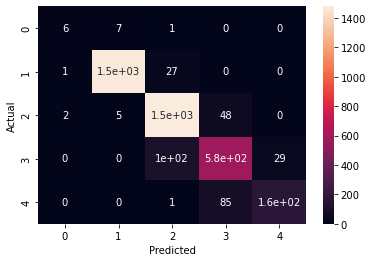

In [18]:
confu_matrix(y_test,y_pred)

In [ ]:
['GreenFlag', 'WhiteFlag', 'YellowFlag', 'OrangeFlag', 'RedFlag'],[0,1,2,3,4])

### Optimization

In [ ]:
X = df.drop(['fecha','firstLabel','secondLabel','nombre'],axis=1)
y = df['secondLabel']
#Dummy variable for ‘segment’ column
segment = pd.get_dummies(X['segment'], drop_first = True)
#Dropping the original ‘segment’
X = X.drop(['segment'], axis = 1)
#Adding the dummy columns to the dataset
X = pd.concat([X,segment], axis = 1)
y = y.replace(['GreenFlag', 'WhiteFlag', 'YellowFlag', 'OrangeFlag', 'RedFlag'],[0,1,2,3,4])

# Split data into train and test sets
X_train, X_val, X_test, y_train, y_val, y_test = data_split(X,y,0.7)
os_us = SMOTETomek()
X_train_, y_train_ = os_us.fit_resample(X_train, y_train)

'''
# Define the model
xgb_model = XGBClassifier()

# Define the parameter grid
param_grid = {
    'max_depth': np.arange(3, 10, 2),
    'learning_rate': [0.05, 0.1, 0.15, 0.2],
    'n_estimators': [50, 100, 150, 200],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'reg_alpha': [0, 0.5, 1],
    'reg_lambda': [1, 1.5, 2],
    'scale_pos_weight': [1, 2, 3, 4],
    'min_child_weight': [1, 2, 3]
}

# Define the random search
random_search = RandomizedSearchCV(xgb_model, param_distributions=param_grid, n_iter=100, cv=5, 
                                   scoring='f1_micro', n_jobs=-1, random_state=42)

# Fit the random search
random_search.fit(X_train_, y_train_)

# Print the best parameters
print(random_search.best_params_)
'''

In [150]:
X = df.drop(['fecha','firstLabel','secondLabel','nombre'],axis=1)
y = df['secondLabel']
#Dummy variable for ‘segment’ column
segment = pd.get_dummies(X['segment'], drop_first = True)
#Dropping the original ‘segment’
X = X.drop(['segment'], axis = 1)
#Adding the dummy columns to the dataset
X = pd.concat([X,segment], axis = 1)
y = y.replace(['GreenFlag', 'WhiteFlag', 'YellowFlag', 'OrangeFlag', 'RedFlag'],[0,1,2,3,4])

X_train, X_val, X_test, y_train, y_val, y_test = data_split(X,y,0.7)
os_us = SMOTETomek()
X_train_, y_train_ = os_us.fit_resample(X_train, y_train)

model = XGBClassifier(subsample=1.0, scale_pos_weight=3, reg_lambda=2, 
                      reg_alpha=0.5, n_estimators=150, min_child_weight=1, 
                      max_depth=7, learning_rate=0.2, colsample_bytree=1.0)
model.fit(X_train_, y_train_)
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print('accuracy:',accuracy)

[10:51:32] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-37/xgboost/src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


accuracy: 0.9236409608091024


In [151]:
report_optimizado = classification_report(y_test,y_pred)
print(report_optimizado)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.99      0.99      0.99      1512
           2       0.91      0.96      0.94      1454
           3       0.81      0.81      0.81       729
           4       0.86      0.64      0.74       259

    accuracy                           0.92      3955
   macro avg       0.72      0.68      0.70      3955
weighted avg       0.92      0.92      0.92      3955



/Users/nestorsanchez/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/nestorsanchez/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/nestorsanchez/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

In [152]:
print(report_sinOptimizar)

              precision    recall  f1-score   support

           0       0.67      0.50      0.57         4
           1       0.99      0.99      0.99      1480
           2       0.93      0.95      0.94      1555
           3       0.81      0.81      0.81       679
           4       0.83      0.68      0.75       237

    accuracy                           0.93      3955
   macro avg       0.84      0.79      0.81      3955
weighted avg       0.93      0.93      0.93      3955



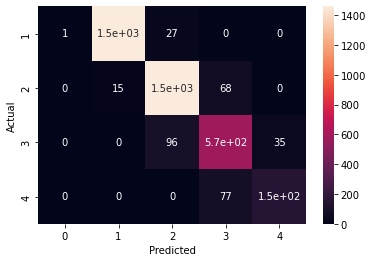

In [147]:
confu_matrix(y_test,y_pred)